In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import genextreme

In [4]:
eps=1e-4
class CustomActivation(nn.Module):
    def forward(self, x):
        x1 = torch.relu(x[:,:,0]) #location : should be positive
        x2 = torch.clamp(x[:,:,1], 0, 0.1)
        #x2 = torch.relu(x[:,:,1]) #scale
        #x3 = x[:,:,2] #shape
        #x3 = - torch.relu(x[:,:,2]) - eps
        x3 = torch.clamp(x[:,:,2],-1,-0.1)
        x = torch.stack([x1, x2, x3], dim=2)
        return x

In [5]:
custom_activation = CustomActivation()
class ANNetwork(nn.Module):
    def __init__(self):
        super(ANNetwork,self).__init__()
        self.fc1=nn.Linear(2,10)
        self.fc2=nn.Linear(10,3)
        ## first output : location, 2nd output : scale, 3rd output : shape
        ##location param can take all values, scale must be >0 and shape between -1 and 1 

    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        x = custom_activation(x)
        return x

model=ANNetwork()

In [6]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()
        self.fc1=nn.Linear(2,10)
        self.fc2=nn.Linear(10,10)
        self.fc3=nn.Linear(10,3)

    def forward(self,x):
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x=self.fc3(x)
        return x

model2=ANN()

In [7]:
def training_set_output(dataset):
    maximum_ = dataset['TOT_PR'].values
    output = torch.tensor(maximum_, dtype=torch.float32)
    output=output.permute(1, 2, 0)
    return output

In [8]:
##Finalement on entraîne avec les maximas pas les params de GEV 

In [9]:
class CustomCRPSLoss(nn.Module):
    def __init__(self):
        super(CustomCRPSLoss, self).__init__()

    def forward(self, y_pred, y_true):
        term_one = torch.mean(torch.abs(y_pred - y_true), dim=-1)
        term_two = torch.mean(torch.abs(
        torch.unsqueeze(y_pred, -1) - torch.unsqueeze(y_pred, -2)), dim=(-2, -1))
        half = torch.tensor(-0.5, dtype=term_two.dtype)
        loss = term_one + half * term_two
        loss = torch.mean(loss)
        return loss

In [10]:
import sklearn.preprocessing as sp
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data"
os.chdir(path)
train_data=xr.open_dataset('train_data_stationnary.nc')
scaler = sp.StandardScaler()
max_pr = train_data['TOT_PR']
max_pr = max_pr.to_numpy()
max_pr = max_pr.flatten()
unscaled_t = max_pr[:, np.newaxis]

scaled_t = scaler.fit_transform(unscaled_t)

print(scaler.mean_, np.sqrt(scaler.var_))
#print(train_data['TOT_PR'])
print(scaled_t)
scaled_t = scaled_t.reshape((312, 101, 176))


[0.00156551] [0.00251181]
[[-0.62326014]
 [-0.62326014]
 [-0.62326014]
 ...
 [ 0.4268593 ]
 [ 0.6050949 ]
 [ 0.7481909 ]]


In [11]:
num_weeks = len(train_data['week'])

In [13]:

nb_lon= len(train_data['rlon'])
nb_lat= len(train_data['rlat'])

rlat = torch.tensor(train_data['rlat'].values)
rlon=torch.tensor(train_data['rlon'].values)
grid_lat, grid_lon = torch.meshgrid(rlat, rlon)
input = torch.stack((grid_lat, grid_lon), dim=-1)
#batch_output = training_set_output(train_data)

batch_output = torch.tensor(scaled_t, dtype=torch.float32)
batch_output = batch_output.permute(1, 2, 0)
batch_output = torch.transpose(batch_output, 0, 1)
batch_output


/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/dev_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[-0.6233,  3.2642, -0.6233,  ..., -0.4601, -0.4304, -0.0727],
         [-0.6233,  3.4604, -0.6233,  ..., -0.4559, -0.4392,  0.0304],
         [-0.6233,  2.1082, -0.6233,  ..., -0.4175, -0.4525,  0.1136],
         ...,
         [-0.6233, -0.2342, -0.6229,  ..., -0.3976, -0.5170, -0.1534],
         [-0.6233, -0.1676, -0.6230,  ..., -0.3837, -0.4516,  0.5577],
         [-0.6233,  0.0312, -0.6230,  ..., -0.3682, -0.3854,  1.0203]],

        [[-0.6233,  4.2864, -0.6233,  ..., -0.4652, -0.4348, -0.0659],
         [-0.6233,  2.2808, -0.6233,  ..., -0.4706, -0.4378,  0.0176],
         [-0.6233,  2.1637, -0.6233,  ..., -0.4505, -0.4457,  0.1067],
         ...,
         [-0.6233, -0.2540, -0.6229,  ..., -0.3399, -0.5255, -0.1829],
         [-0.6233, -0.2935, -0.6230,  ..., -0.3692, -0.4708,  0.1089],
         [-0.6233, -0.1275, -0.6230,  ..., -0.3486, -0.3675,  0.8432]],

        [[-0.6233,  1.2248, -0.6233,  ..., -0.5088, -0.4324, -0.1213],
         [-0.6233,  1.6048, -0.6233,  ..., -0

EPOCH :  0
sample after change tensor([[[ 4.8499,  7.9693,  3.7737,  ...,  9.0091,  6.6916,  5.8600],
         [ 7.9297,  6.8367,  6.1563,  ...,  8.1235,  6.0308,  9.1254],
         [ 8.4210,  6.7770,  3.2862,  ...,  6.4035,  4.7311,  9.9971],
         ...,
         [ 9.4763,  6.7583,  8.9829,  ...,  8.6779,  8.6354,  8.0496],
         [ 5.8805,  5.9413,  6.5361,  ...,  9.6485,  9.3860,  9.6281],
         [10.0198,  8.6448,  4.7021,  ...,  7.8777,  8.4445,  7.4396]],

        [[ 7.9116,  6.2063,  5.8169,  ...,  7.1819,  3.5017,  8.9058],
         [ 3.5228,  4.4660,  6.2845,  ...,  8.4403,  4.2146,  8.5394],
         [ 5.3814,  9.2088,  8.3767,  ...,  0.9190,  9.1846,  8.3694],
         ...,
         [ 7.2101,  7.4494,  7.5169,  ...,  9.3111,  8.5019,  8.9011],
         [ 8.8976,  8.5522, 10.4721,  ...,  9.9812,  4.4800,  3.3523],
         [ 7.4935, 10.0757,  4.6143,  ...,  9.3766,  9.4417,  9.8065]],

        [[ 7.5258,  7.2983,  7.5530,  ...,  8.1131,  4.1295,  4.2626],
         [ 7.3

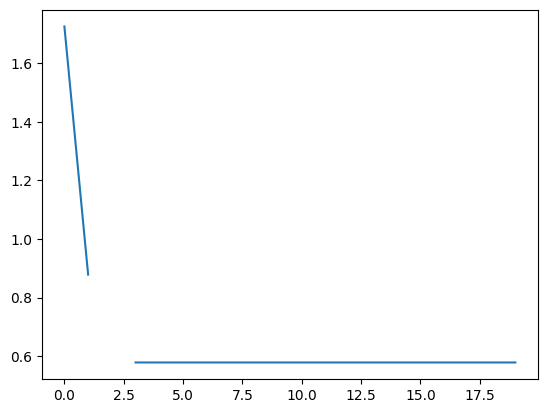

In [14]:
num_epoch=20
train_len=num_weeks

optimizer1= torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer2= torch.optim.Adam(model2.parameters(), lr=0.01)
loss_crps=CustomCRPSLoss()
loss_list1=[]
loss_list2=[]

for epoch in range(num_epoch):
        print('EPOCH : ',epoch)
        outputs_lnn=model(input)

        loc, scale, c = outputs_lnn[:,:,0],outputs_lnn[:,:,1],outputs_lnn[:,:,2]

        ## Générer les échantillons :  
        size = (nb_lon,nb_lat,batch_output.shape[2])
        u = torch.rand(size)

        ##Adapter la forme des paramètres de GEV 
        c = c.unsqueeze(-1).repeat(1, 1, size[2])
        c = torch.transpose(c, 0, 1)
        #print('c',c)

        scale = scale.unsqueeze(-1).repeat(1, 1, size[2])
        scale = torch.transpose(scale, 0, 1)
        #print(scale)
        #print('scale/c',scale/c)
        loc=loc.unsqueeze(-1).repeat(1, 1, size[2])
        loc = torch.transpose(loc, 0, 1)

        sample = loc + (scale / c) * ((-torch.log(u)) ** (-c) - 1) 
        #print(sample)
        sample = (sample - 0.00156551) / np.sqrt(0.00251181)
        sample[np.isnan(torch.detach(sample).numpy())] = 0
        print('sample after change',sample)
        #print('log(u) puissance c',(-torch.log(u)) ** (-c))
        #sample=torch.abs(sample)
        has_nan = np.isnan(torch.detach(sample).numpy()).any()
        
        if has_nan:
            print("Le tensor contient au moins un NaN.")
        else:
            print("Le tensor ne contient pas de NaN.")
        #print('sample',sample)
        loss1=loss_crps(sample,batch_output)
        print(loss1)
        loss_list1.append(torch.detach(loss1).numpy())
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        print(model.parameters())
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss1.item():.4f}')
plt.plot(loss_list1)
plt.show()

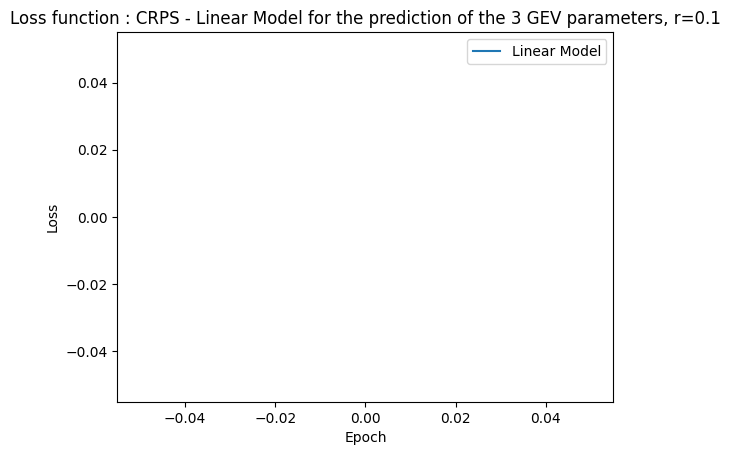

In [26]:
plt.plot(loss_list1, label='Linear Model')

plt.title('Loss function : CRPS - Linear Model for the prediction of the 3 GEV parameters, r=0.1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
##pas toucher :

loss_list_begin=loss_list1

In [32]:
loss_list

NameError: name 'loss_list' is not defined

In [33]:
print(outputs)

NameError: name 'outputs' is not defined

In [56]:
input_test=torch.tensor([1.0,1.0])
output_test=model2(input_test)

In [57]:
output_test

tensor([nan, nan, nan], grad_fn=<AddBackward0>)

In [ ]:
##vérifier ! 